# AVALIAÇÃO DE ACESSIBILIDADE EM APLICAÇÕES WEB UTILIZANDO UM WEB CRAWLER E A FERRAMENTA AXE-CORE

### UNIVERSIDADE TECNOLÓGICA FEDERAL DO PARANÁ
### CURSO DE ENGENHARIA DA COMPUTAÇÃO

## Lucas Paschoalick

In [11]:
from selenium import webdriver
from axe_selenium_python import Axe
import json
import os
import time
import matplotlib.pyplot as plt
import numpy as np

In [43]:
# funçoes do projeto

# Função para extrair as informações necessárias dos resultados do Axe-core
def extract_info(results):
    violations_info = []
    for violation in results["violations"]:
        description = violation["description"]
        impact = violation["impact"]
        tags = violation["tags"]
        nodes = len(violation["nodes"])
        violation_info = {
            "description": description,
            "impact": impact,
            "tags": tags,
            "num_nodes_violated": nodes,
        }
        violations_info.append(violation_info)
    return violations_info

# Função para salvar screenshot da tela de cada site
def save_site_screenshot(driver, site):
    screenshot_name = f"{site}.png"    
    screenshot_path = os.path.join(screenshot_dir, screenshot_name)
    driver.save_screenshot(screenshot_path)

# Função para executar os testes
def axe_test(driver, site):
    axe = Axe(driver)
    axe.inject()
    results = axe.run()
    
    results_name = f"{site}.json"
    results_path = os.path.join(json_results_dir, results_name)
    
    with open(results_path, "w") as f:
        json.dump(results, f, indent=4)
    
    violations_info = extract_info(results)
    filtered_results_path = os.path.join(filtered_results_dir, results_name)
    with open(filtered_results_path, "w") as f:
        json.dump(violations_info, f, indent=4)
    
    return violations_info

# Função para salvar json com sites que deram erro no teste
def save_error_sites(error_list):
    error_sites_file = "errorSites.json"    
    error_sites_path = os.path.join(error_sites_dir, error_sites_file)
    
    with open(error_sites_path, "w") as f:
        json.dump(error_list, f, indent=4) 
        
# Função para salvar json com sites sem erro no teste
def save_sites_without_violations(sites_without_violations):
    with open('sites_sem_violacoes.json', 'w') as json_file:
        json.dump(sites_without_violations, json_file, indent=4, ensure_ascii=False)
        
# Função para criar e salvar gráficos
def create_bar_graph(data_dict, title, x_label, y_label, identifier=0, show_legend=False, rotation=90):
    plt.figure(figsize=(20, 15))

    if identifier == 0:
        sorted_dict = dict(sorted(data_dict.items(), key=lambda item: item[1], reverse=True))
        x_values = list(sorted_dict.keys())
        y_values = list(sorted_dict.values())
    elif identifier == 1:
        sorted_dict = dict(sorted(data_dict.items(), key=lambda item: item[1]["count"], reverse=True))
        x_values = list(sorted_dict.keys())
        y_values = [sorted_dict[description]["count"] for description in x_values]

    plt.bar(x_values, y_values)

    if show_legend:
        plt.legend()

    plt.xticks(rotation=rotation)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    
    # Aumentar o tamanho do texto no eixo x e quebrar linhas por palavra
#     x_values_formatted = []
#     for text in x_values:
#         words = text.split(' ')
#         lines = []
#         line_length = 0
#         line = []
#         for word in words:
#             if line_length + len(word) > 100:
#                 lines.append(' '.join(line))
#                 line = [word]
#                 line_length = len(word)
#             else:
#                 line.append(word)
#                 line_length += len(word)
#         lines.append(' '.join(line))
#         x_values_formatted.append('\n'.join(lines[:10]))
    
#     plt.xticks(range(len(x_values)), x_values_formatted, fontsize=15)
#     plt.gca().tick_params(axis='x', which='major', pad=20)

    plt.tight_layout()

    graph_image_name = title
    graphs_path = os.path.join('images/imageGraphs', graph_image_name + ".png")
    plt.savefig(graphs_path)

# Função para criar pastas do projeto
def make_dir(dir_name):    
    os.makedirs(dir_name, exist_ok=True)
    return dir_name

# Função para contabilizar a ocorrência de cada violação por descrição
def count_occurrences_by_description(violations_info):
    violations_count = {}
    
    for site_violations in violations_info:
        for violation in site_violations:
            description = violation["description"]
            
            if description not in violations_count:
                violations_count[description] = 0
            
            violations_count[description] += 1
    
    return violations_count

# Função para calcular a media de ocorrências de cada violação
def average_violations_by_description(results_dir):
    total_violations_by_description = {}
    total_violations = 0

    json_files = [f for f in os.listdir(results_dir) if f.endswith(".json")]

    for json_file in json_files:
        with open(os.path.join(results_dir, json_file), "r") as f:
            results = json.load(f)

        for violation in results:
            description = violation["description"]
            num_violations_node = violation["num_nodes_violated"]

            if description not in total_violations_by_description:
                total_violations_by_description[description] = 0

            total_violations_by_description[description] += num_violations_node
            total_violations += num_violations_node

    average_violations = {}

    for description, total_violations_for_type in total_violations_by_description.items():
        percentage = (total_violations_for_type / total_violations) * 100
        average_violations[description] = percentage

    return average_violations

# Função para contar o número de websites que apresentam determinadas violações
def count_websites_by_violation(results_dir, total_violations_by_description):
    websites_by_violation = {}
    
    for description in total_violations_by_description.keys():        
        websites_by_violation[description] = {"sites": [], "count": 0}
    
    # Listar os arquivos JSON na pasta de resultados
    json_files = [f for f in os.listdir(results_dir) if f.endswith(".json")]

    for json_file in json_files:
        with open(os.path.join(results_dir, json_file), "r") as f:
            results = json.load(f)

        site_name = json_file.split(".json")[0]

        for violation in results:
            description = violation["description"]
            websites_by_violation[description]["sites"].append(site_name)
            websites_by_violation[description]["count"] += 1

    return websites_by_violation

# Função para salvar arquivos JSON
def save_to_json(data, output_file):
    with open(output_file, "w") as json_file:
        json.dump(data, json_file, indent=4)
        
# def calculate_total_violations_by_description(results_dir):
#     total_violations_by_description = {}
    
#     json_files = [f for f in os.listdir(results_dir) if f.endswith(".json")]

#     for json_file in json_files:
#         with open(os.path.join(results_dir, json_file), "r") as f:
#             results = json.load(f)

#         for violation in results:
#             description = violation["description"]
#             num_violations_node = violation["num_nodes_violated"]

#             if description not in total_violations_by_description:
#                 total_violations_by_description[description] = 0

#             total_violations_by_description[description] += num_violations_node

#     return total_violations_by_description

# results_dir = "results/filteredResults"
# total_violations = calculate_total_violations_by_description(results_dir)
# save_to_json(total_violations, "total_number_violations_by_description.json")

In [5]:
start_time = time.time()

# Configurações para o Driver do Chrome
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--window-size=1280x720")
chrome_options.add_argument("incognito")

driver = webdriver.Chrome(options=chrome_options)

driver.set_script_timeout(3)

In [6]:
# Criação de diretórios para armazenar os arquivos
all_results_dir = make_dir("results")
json_results_dir = make_dir("results/jsonResults")
filtered_results_dir = make_dir("results/filteredResults")
sites_with_no_error = make_dir("results/sitesWithNoError")
error_sites_dir = make_dir("results/sitesWithError")

images_dir = make_dir("images")
screenshot_dir = make_dir("images/screenshots")
graphs_dir = make_dir("images/imageGraphs")

In [7]:
# Declaração de Dicionários e listas
violations_count = {}
sites_violations_count = {}
error_sites = []
sites_sem_violacoes = []

In [8]:
# lista de sites
url_path = "urlList/url_list_alexa.txt"
with open(url_path, "r") as file:
    websites = file.read().splitlines()

# Iteração nos websites para executar os testes
for i, website in enumerate(websites):
    try:
        driver.get(website)        
        
        site = website.split('.')[1]
        
        save_site_screenshot(driver, site)
        violations_info = axe_test(driver, site)
    
        if violations_info is None or not violations_info:
            sites_sem_violacoes.append(site)

    except Exception as e:
        print(f"Erro ao analisar o website: {website}")
        print(e)
        error_sites.append(website)
        
    print(website)
    print(f"Progresso: {i+1}/{len(websites)}")

save_error_sites(error_sites)

save_sites_without_violations(sites_sem_violacoes)

occurrences_by_description = count_occurrences_by_description(violations_info)
save_to_json(occurrences_by_description, "violations_occurrences.json")

driver.quit()

end_time = time.time()
elapsed_time = end_time - start_time
        
print(f"Tempo de execução: {elapsed_time:.2f} segundos")

http://www.google.com
Progresso: 1/467
Erro ao analisar o website: http://www.youtube.com
Message: script timeout
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF63999045D]
	(No symbol) [0x00007FF639A0B6BE]
	(No symbol) [0x00007FF6399F20AA]
	(No symbol) [0x00007FF639A0AAA4]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No symbol) [0x00007FF639ADD062]
	(No symbol) [0x00007FF639ACD3A3]
	BaseThreadInitThunk [0x00007FFC952C7344+20]
	RtlUserThreadStart [0x00007FFC96C026B1+33]

http://www.youtube.com
Progresso: 2/467
http://www.tmall.com
Progresso: 3/467
http://www.b

http://www.amazon.in
Progresso: 41/467
http://www.huanqiu.com
Progresso: 42/467
http://www.stackoverflow.com
Progresso: 43/467
Erro ao analisar o website: http://www.tianya.cn
Message: unknown error: net::ERR_NAME_NOT_RESOLVED
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63998C353]
	(No symbol) [0x00007FF63997F4CC]
	(No symbol) [0x00007FF639980714]
	(No symbol) [0x00007FF63997F8DF]
	(No symbol) [0x00007FF63997E803]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D803]
	(No symbol) [0x00007FF6399929BF]
	(No symbol) [0x00007FF639A0AE27]
	(No symbol) [0x00007FF6399F20AA]
	(No symbol) [0x00007FF639A0AAA4]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4

http://www.cnblogs.com
Progresso: 93/467
Erro ao analisar o website: http://www.walmart.com
Message: script timeout
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF63999045D]
	(No symbol) [0x00007FF639A0B6BE]
	(No symbol) [0x00007FF6399F20AA]
	(No symbol) [0x00007FF639A0AAA4]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No symbol) [0x00007FF639ADD062]
	(No symbol) [0x00007FF639ACD3A3]
	BaseThreadInitThunk [0x00007FFC952C7344+20]
	RtlUserThreadStart [0x00007FFC96C026B1+33]

http://www.walmart.com
Progresso: 94/467
http://www.salesforce.com
Progresso: 95/467
htt

http://www.51sole.com
Progresso: 151/467
http://www.researchgate.net
Progresso: 152/467
http://www.suara.com
Progresso: 153/467
http://www.deepl.com
Progresso: 154/467
Erro ao analisar o website: http://www.aliyun.com
Message: script timeout
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF63999045D]
	(No symbol) [0x00007FF639A0B6BE]
	(No symbol) [0x00007FF6399F20AA]
	(No symbol) [0x00007FF639A0AAA4]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No symbol) [0x00007FF639ADD062]
	(No symbol) [0x00007FF639ACD3A3]
	BaseThreadInitThunk [0x00007FFC952C7344+20]
	RtlUse

Erro ao analisar o website: http://www.gosuslugi.ru
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(N

Erro ao analisar o website: http://www.tudou.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No s

Erro ao analisar o website: http://www.coursera.org
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(N

Erro ao analisar o website: http://www.trendyol.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(N

Erro ao analisar o website: http://www.etoro.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No s

Erro ao analisar o website: http://www.wikihow.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No

Erro ao analisar o website: http://www.bet365.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No 

Erro ao analisar o website: http://www.mercadolibre.com.mx
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF

Erro ao analisar o website: http://www.shaparak.ir
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No

Erro ao analisar o website: http://www.sahibinden.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	

Erro ao analisar o website: http://www.wildberries.ru
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	

Erro ao analisar o website: http://www.americanexpress.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF

Erro ao analisar o website: http://www.linktr.ee
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No s

Erro ao analisar o website: http://www.ask.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No sym

Erro ao analisar o website: http://www.adp.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No sym

Erro ao analisar o website: http://www.fc2.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No sym

Erro ao analisar o website: http://www.patreon.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No

Erro ao analisar o website: http://www.liansuo.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No

Erro ao analisar o website: http://www.tv9marathi.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	

Erro ao analisar o website: http://www.gusuwang.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(N

Erro ao analisar o website: http://www.bbcollab.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(N

Erro ao analisar o website: http://www.ameritrade.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	

Erro ao analisar o website: http://www.ladbible.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(N

Erro ao analisar o website: http://www.rezka.ag
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No sy

Erro ao analisar o website: http://www.cambridge.org
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(

Erro ao analisar o website: http://www.kapanlagi.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(

Erro ao analisar o website: http://www.ensonhaber.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	

Erro ao analisar o website: http://www.yts.mx
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No symb

Erro ao analisar o website: http://www.9gag.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No sy

Erro ao analisar o website: http://www.laodong.vn
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No 

Erro ao analisar o website: http://www.envato.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No 

Erro ao analisar o website: http://www.divar.ir
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No sy

Erro ao analisar o website: http://www.constantcontact.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF

Erro ao analisar o website: http://www.outbrain.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(N

Erro ao analisar o website: http://www.springer.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(N

Erro ao analisar o website: http://www.104.com.tw
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No 

Erro ao analisar o website: http://www.genius.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]
	(No 

Erro ao analisar o website: http://www.mheducation.com
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007FF639ADCF34]


Erro ao analisar o website: http://www.incometaxindiaefiling.gov.in
Message: timeout: Timed out receiving message from renderer: 300.000
  (Session info: headless chrome=119.0.6045.159)
Stacktrace:
	GetHandleVerifier [0x00007FF639B682B2+55298]
	(No symbol) [0x00007FF639AD5E02]
	(No symbol) [0x00007FF6399905AB]
	(No symbol) [0x00007FF63997E997]
	(No symbol) [0x00007FF63997E7A8]
	(No symbol) [0x00007FF63997CF0E]
	(No symbol) [0x00007FF63997D9CE]
	(No symbol) [0x00007FF63998A20F]
	(No symbol) [0x00007FF63999B551]
	(No symbol) [0x00007FF63999FC1A]
	(No symbol) [0x00007FF63997E032]
	(No symbol) [0x00007FF63999B42A]
	(No symbol) [0x00007FF639A0A9C8]
	(No symbol) [0x00007FF6399F1E83]
	(No symbol) [0x00007FF6399C670A]
	(No symbol) [0x00007FF6399C7964]
	GetHandleVerifier [0x00007FF639EE0AAB+3694587]
	GetHandleVerifier [0x00007FF639F3728E+4048862]
	GetHandleVerifier [0x00007FF639F2F173+4015811]
	GetHandleVerifier [0x00007FF639C047D6+695590]
	(No symbol) [0x00007FF639AE0CE8]
	(No symbol) [0x00007

TypeError: string indices must be integers

In [9]:
# Calcular Média de violações por Websites e Número de Websites para Cada Violação e salvar em JSON

results_dir = "results/filteredResults"

average_violations = average_violations_by_description(results_dir)
save_to_json(average_violations, "average_violations.json")

websites_by_violation = count_websites_by_violation(results_dir, average_violations)
save_to_json(websites_by_violation, "count_websites_by_violation.json")

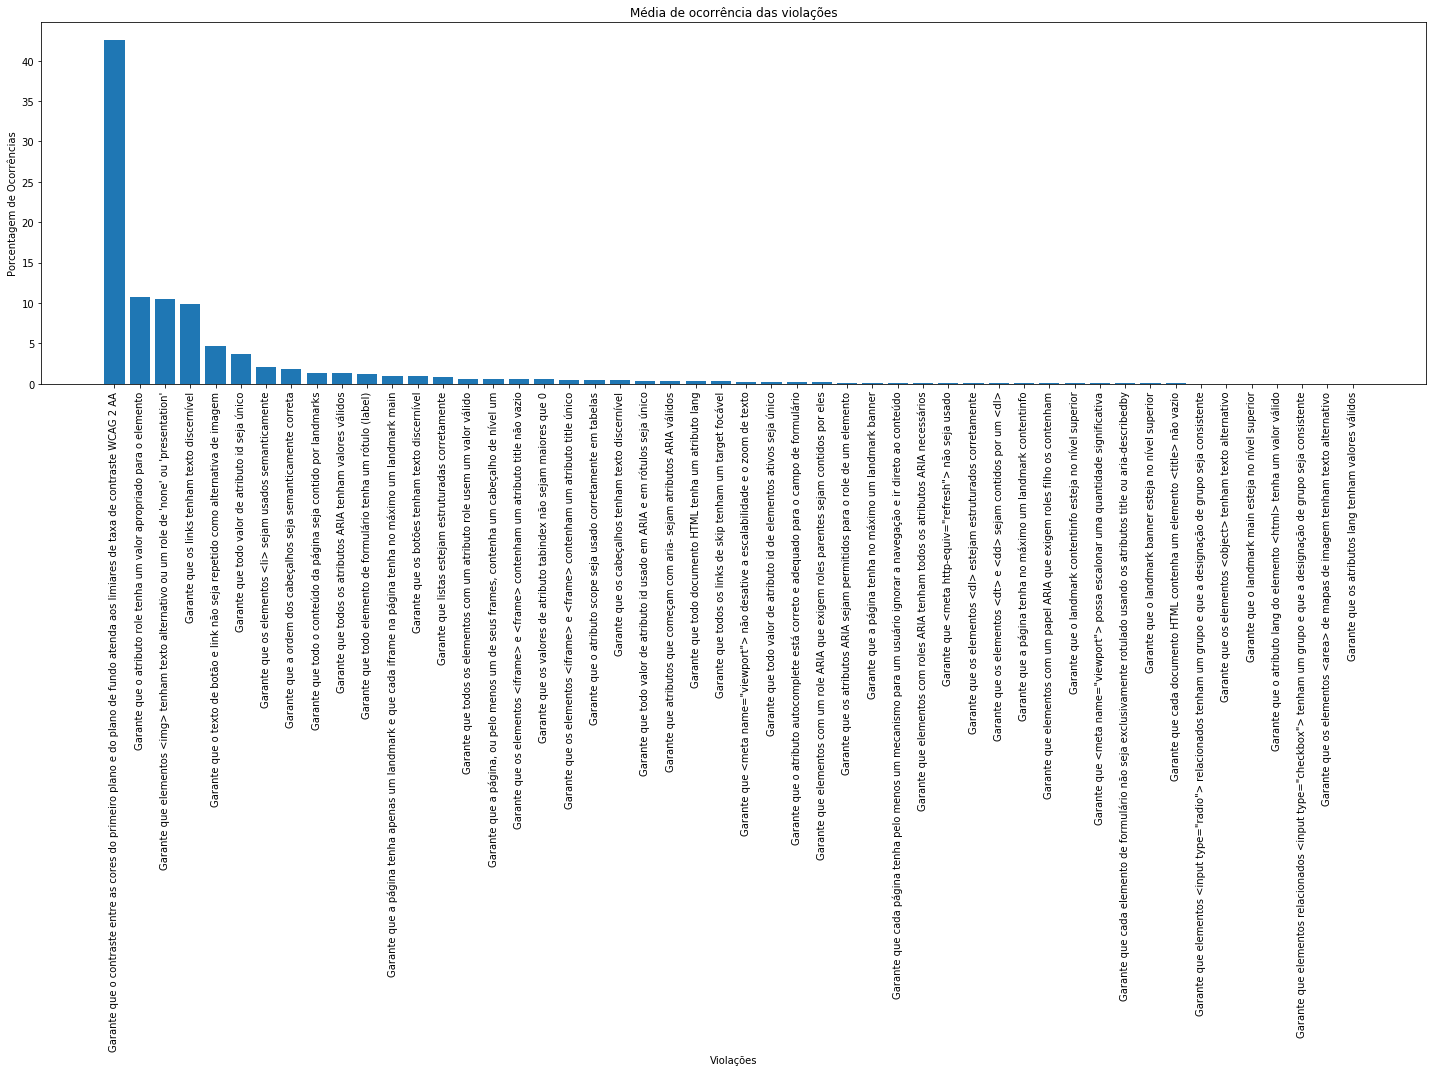

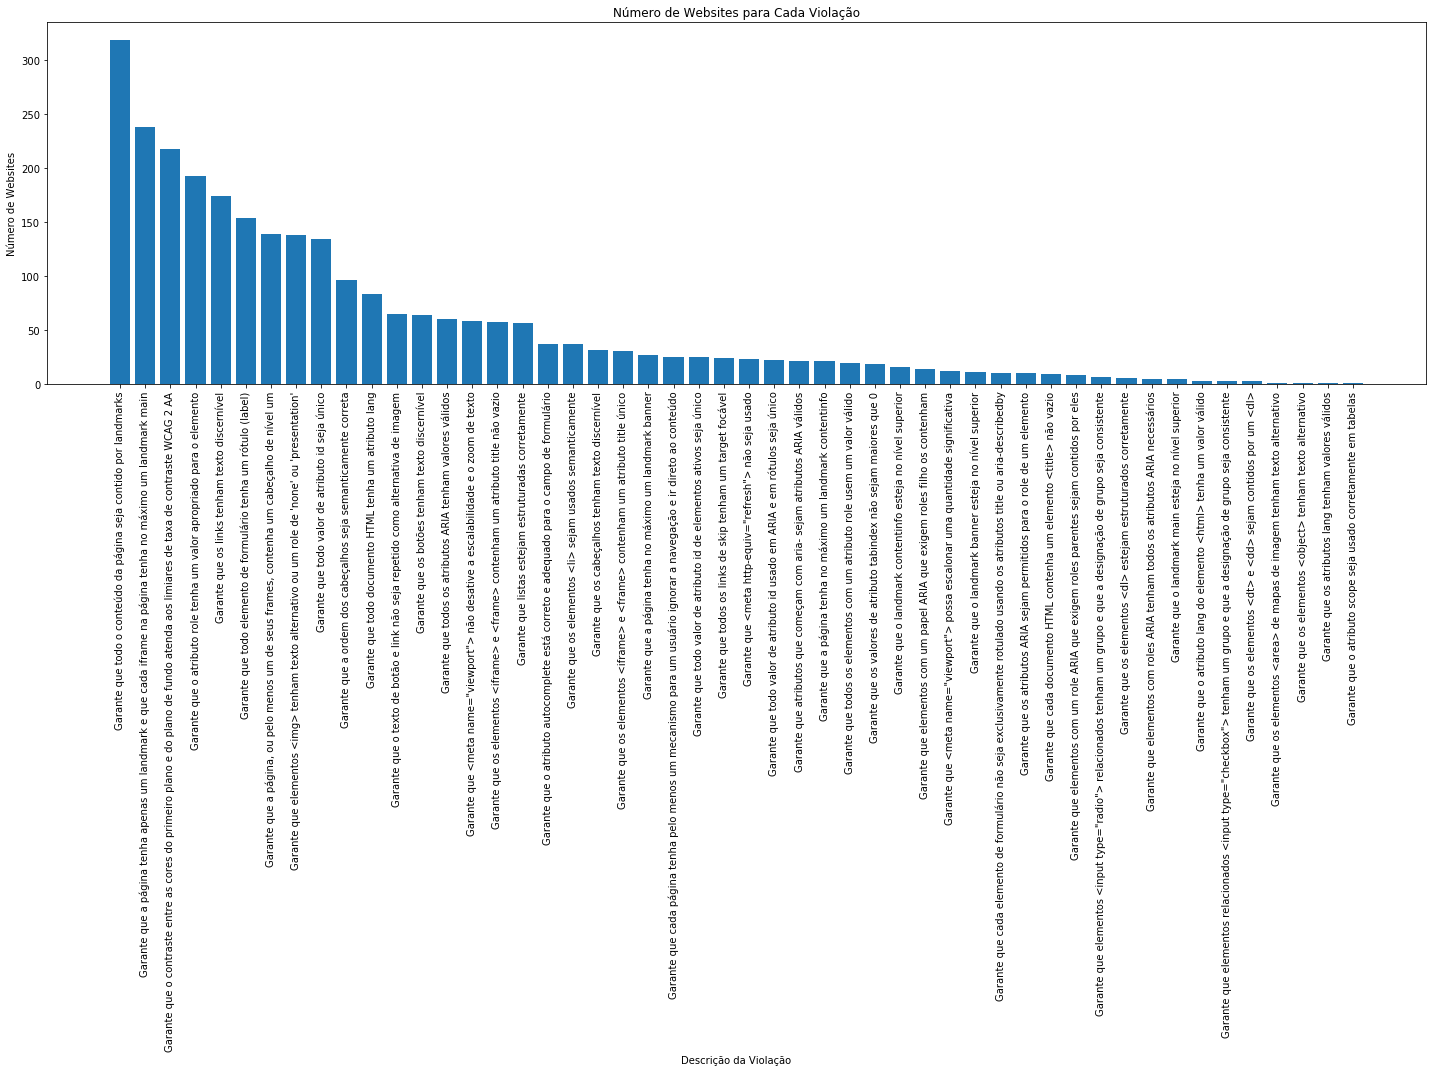

In [44]:
with open('media_violacoes.json', 'r', encoding='utf-8') as file:
    media_violacoes = json.load(file)
    
with open('websites_por_violacao.json', 'r', encoding='utf-8') as file:
    websites_por_violacao = json.load(file)
    
# Criar gráficos
create_bar_graph(media_violacoes, "Média de ocorrência das violações", "Violações", "Porcentagem de Ocorrências", identifier=0)
create_bar_graph(websites_por_violacao, "Número de Websites para Cada Violação", "Descrição da Violação", "Número de Websites", identifier=1)

# create_bar_graph(media_violacoes, "Média de ocorrência das violações (10 mais frequentes)", "Violações", "Porcentagem de Ocorrências", identifier=0)
# create_bar_graph(websites_por_violacao, "Número de Websites para Cada Violação (10 mais frequentes)", "Descrição da Violação", "Número de Websites", identifier=1)